### Analysis_2
1. Calculate yearly movie average rating and the trend (based on movie produced year)
2. Calculate yearly average number of rating each user gave and the trend (based on user rating timestamp)
3. Use top five rated movies(movies with most ratings) to analyze whether previous rating will influence the rest

In [1]:
import os
import pandas as pd
from pandas import DataFrame as df
from datetime import datetime
import time
import pytz
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [2]:
rootdir = os.path.expanduser('~')+'/final/data/ml-20m-dataset'

In [3]:
ratings = pd.read_csv(rootdir+'/ratings.csv')
movies = pd.read_csv(rootdir+'/movies.csv')

#### Calculate yearly movie average rating and the trend (based on movie produced year) 

In [4]:
rating_mean = ratings[['rating','movieId']].groupby('movieId').mean().reset_index()

In [5]:
rating_mean.head(4)

,movieId,rating
0,1,3.921240
1,2,3.211977
2,3,3.151040
3,4,2.861393


In [6]:
movies['year'] = movies['title'].apply(lambda x: x[-5:-1])

In [7]:
year_filter = movies['title'].apply(lambda x: True if x[-5:-1].isdigit() else False)

In [8]:
movies = movies[year_filter]

In [9]:
m_r_merged = movies.merge(rating_mean, on='movieId', how='inner')

In [10]:
m_r_merged.head(5)

,movieId,title,genres,year,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,3.921240
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995,3.211977
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,3.151040
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995,2.861393
4,5,Father of the Bride Part II (1995),Comedy,1995,3.064592


In [11]:
df_q1 = m_r_merged[['year','rating']].groupby('year').mean().reset_index()
df_q1.head(5)

,year,rating
0,1891,3.000000
1,1893,3.375000
2,1894,3.071429
3,1895,3.125000
4,1896,3.183036


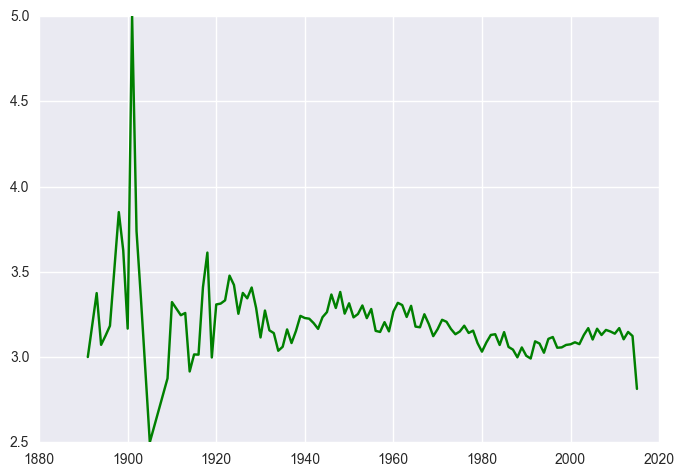

In [12]:
x1 = df_q1['year']
data1 = df_q1['rating']
plt.plot(x1, data1, color ='g')
plt.show()

#### Calculate yearly average number of rating each user gave and the trend (based on user rating timestamp)
就是，所有user每年评分的数量的平均数的变化，这是要用timestamp那个<br>
比如说，用户1在05年评价了10部，2在05年评价了20部，平均就是15呗。06年分别是8和18，平均就变成13了。想知道用户参与度的变化。<br>

In [13]:
ny_tz = pytz.timezone('America/New_York')

In [14]:
t = datetime(1970,1,1)

In [15]:
datetime.fromtimestamp(time.mktime(t.timetuple())+1112484819,ny_tz)

datetime.datetime(2005, 4, 2, 23, 33, 39, tzinfo=<DstTzInfo 'America/New_York' EST-1 day, 19:00:00 STD>)

In [16]:
def calc_time(sr):
    return datetime.fromtimestamp(time.mktime(t.timetuple())+sr,ny_tz)

In [17]:
ratings['rateTime'] = ratings['timestamp'].apply(calc_time)

In [18]:
ratings.head(2)

,userId,movieId,rating,timestamp,rateTime
0,1,2,3.5,1112486027,2005-04-02 23:53:47-05:00
1,1,29,3.5,1112484676,2005-04-02 23:31:16-05:00


In [19]:
ratings['rateYear']=ratings['rateTime'].apply(lambda x:x.year)

In [20]:
ratings.head(5)

,userId,movieId,rating,timestamp,rateTime,rateYear
0,1,2,3.5,1112486027,2005-04-02 23:53:47-05:00,2005
1,1,29,3.5,1112484676,2005-04-02 23:31:16-05:00,2005
2,1,32,3.5,1112484819,2005-04-02 23:33:39-05:00,2005
3,1,47,3.5,1112484727,2005-04-02 23:32:07-05:00,2005
4,1,50,3.5,1112484580,2005-04-02 23:29:40-05:00,2005


In [21]:
df_y_avgnum = ratings.groupby('rateYear').apply(lambda x: x.groupby('userId')['userId'].count().mean()).reset_index()
df_y_avgnum.head()

,rateYear,0
0,1995,2.000000
1,1996,62.226857
2,1997,62.006369
3,1998,82.504017
4,1999,127.136007


In [22]:
df_y_avgnum.columns = ['year','avgRateNum']

In [23]:
df_y_avgnum

,year,avgRateNum
0,1995,2.000000
1,1996,62.226857
2,1997,62.006369
3,1998,82.504017
4,1999,127.136007
5,2000,130.209211
6,2001,113.352924
7,2002,109.220018
8,2003,120.450930
9,2004,134.041586


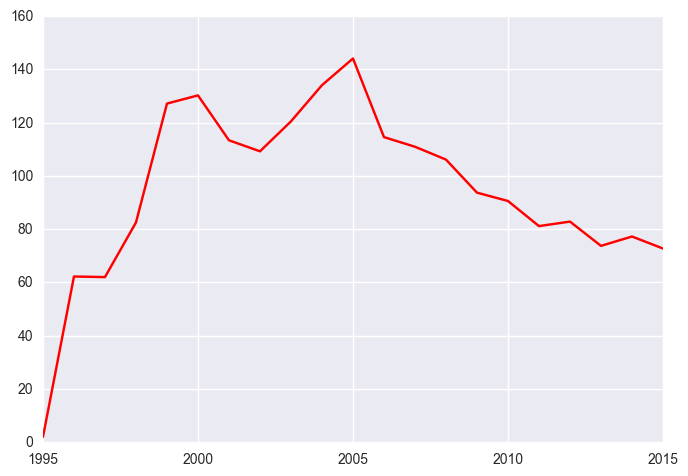

In [24]:
x2 = df_y_avgnum['year']
data2 = df_y_avgnum['avgRateNum']
plt.plot(x2, data2, color ='r')
plt.show()

#### Analyze how existing rating impact followers' rating
Although it's better to solve this problem using machine learning, however I have never learnt it...I tried to solve it using a more straightforward way - accumulative average and watch out for margin. <br>
I'll choose five movies with most number of ratings and observe how the rating changes.

In [25]:
df_top5_rated = ratings[['movieId','rating']].groupby('movieId').count().reset_index().sort_values(by='rating',ascending=False).head()

In [26]:
df_top5_rated

,movieId,rating
293,296,67310
352,356,66172
315,318,63366
587,593,63299
476,480,59715


In [27]:
df_top5_ratedMovie = movies[['movieId','title']].merge(df_top5_rated[['movieId']])

这里是要多加一个column计算accumulative average, 怎么算呢？就是到该行为止的该电影的平均数<br>
方法：expanding_mean

In [28]:
df_top5_ratedMovie

,movieId,title
0,296,Pulp Fiction (1994)
1,318,"Shawshank Redemption, The (1994)"
2,356,Forrest Gump (1994)
3,480,Jurassic Park (1993)
4,593,"Silence of the Lambs, The (1991)"


In [29]:
df_r_m_merged = ratings.merge(df_top5_ratedMovie)[['movieId','title','rateTime','rating']]

In [30]:
df_r_m_merged.head()

,movieId,title,rateTime,rating
0,296,Pulp Fiction (1994),2005-04-02 23:32:47-05:00,4.0
1,296,Pulp Fiction (1994),1996-06-05 12:11:21-04:00,5.0
2,296,Pulp Fiction (1994),2009-01-02 01:13:19-05:00,3.5
3,296,Pulp Fiction (1994),1996-11-27 08:12:46-05:00,5.0
4,296,Pulp Fiction (1994),1996-08-16 15:44:02-04:00,3.0


In [31]:
df_id296 = df_r_m_merged[df_r_m_merged['movieId']==296].sort_values(by='rateTime').reset_index(drop=True)

In [32]:
df_id296['accumulativeMeanRating'] = df_id296['rating'].expanding().mean()

In [33]:
df_id296.head()

,movieId,title,rateTime,rating,accumulativeMeanRating
0,296,Pulp Fiction (1994),1996-02-29 16:48:44-05:00,5.0,5.000000
1,296,Pulp Fiction (1994),1996-03-01 00:00:00-05:00,5.0,5.000000
2,296,Pulp Fiction (1994),1996-03-01 00:00:00-05:00,4.0,4.666667
3,296,Pulp Fiction (1994),1996-03-01 00:00:00-05:00,4.0,4.500000
4,296,Pulp Fiction (1994),1996-03-01 00:00:00-05:00,5.0,4.600000


In [34]:
df_id318 = df_r_m_merged[df_r_m_merged['movieId']==318].sort_values(by='rateTime').reset_index(drop=True)

In [35]:
df_id318['accumulativeMeanRating'] = df_id318['rating'].expanding().mean()

In [36]:
df_id318.head(4)

,movieId,title,rateTime,rating,accumulativeMeanRating
0,318,"Shawshank Redemption, The (1994)",1996-03-01 00:00:00-05:00,5.0,5.000000
1,318,"Shawshank Redemption, The (1994)",1996-03-02 18:04:28-05:00,3.0,4.000000
2,318,"Shawshank Redemption, The (1994)",1996-03-08 14:17:38-05:00,5.0,4.333333
3,318,"Shawshank Redemption, The (1994)",1996-03-13 19:26:32-05:00,5.0,4.500000


In [37]:
df_id356 = df_r_m_merged[df_r_m_merged['movieId']==356].sort_values(by='rateTime').reset_index(drop=True)

In [38]:
df_id356['accumulativeMeanRating'] = df_id356['rating'].expanding().mean()

In [39]:
df_id356.head(4)

,movieId,title,rateTime,rating,accumulativeMeanRating
0,356,Forrest Gump (1994),1996-03-01 00:00:00-05:00,2.0,2.000000
1,356,Forrest Gump (1994),1996-03-01 00:00:00-05:00,4.0,3.000000
2,356,Forrest Gump (1994),1996-03-01 00:00:00-05:00,4.0,3.333333
3,356,Forrest Gump (1994),1996-03-01 00:00:00-05:00,3.0,3.250000


In [40]:
df_id480 = df_r_m_merged[df_r_m_merged['movieId']==480].sort_values(by='rateTime').reset_index(drop=True)

In [41]:
df_id480['accumulativeMeanRating'] = df_id480['rating'].expanding().mean()

In [42]:
df_id480.head(4)

,movieId,title,rateTime,rating,accumulativeMeanRating
0,480,Jurassic Park (1993),1996-03-01 00:00:00-05:00,5.0,5.00
1,480,Jurassic Park (1993),1996-03-01 00:00:00-05:00,3.0,4.00
2,480,Jurassic Park (1993),1996-03-01 00:00:00-05:00,1.0,3.00
3,480,Jurassic Park (1993),1996-03-01 00:00:00-05:00,2.0,2.75


In [43]:
df_id593 = df_r_m_merged[df_r_m_merged['movieId']==593].sort_values(by='rateTime').reset_index(drop=True)

In [44]:
df_id593['accumulativeMeanRating'] = df_id593['rating'].expanding().mean()

In [45]:
df_id593.head(4)

,movieId,title,rateTime,rating,accumulativeMeanRating
0,593,"Silence of the Lambs, The (1991)",1996-03-01 00:00:00-05:00,5.0,5.0
1,593,"Silence of the Lambs, The (1991)",1996-03-01 00:00:00-05:00,5.0,5.0
2,593,"Silence of the Lambs, The (1991)",1996-04-16 09:48:54-04:00,5.0,5.0
3,593,"Silence of the Lambs, The (1991)",1996-04-30 14:38:15-04:00,5.0,5.0


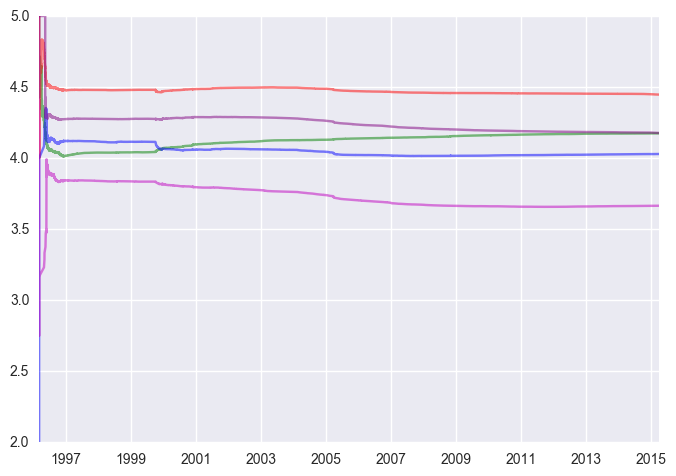

In [46]:
t1 = df_id296['rateTime']
r1 = df_id296['accumulativeMeanRating']
t2 = df_id318['rateTime']
r2 = df_id318['accumulativeMeanRating']
t3 = df_id356['rateTime']
r3 = df_id356['accumulativeMeanRating']
t4 = df_id480['rateTime']
r4 = df_id480['accumulativeMeanRating']
t5 = df_id593['rateTime']
r5 = df_id593['accumulativeMeanRating']


plt.plot(t1, r1, color ='g',alpha=0.5)
plt.plot(t2, r2, color ='r',alpha=0.5)
plt.plot(t3, r3, color ='b',alpha=0.5)
plt.plot(t4, r4, color ='m',alpha=0.5)
plt.plot(t5, r5, color ='purple',alpha=0.5)

plt.show()